In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [35]:
train_feats = pd.read_csv('../../feature_eng/example_features.csv')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

## Classifier

In [74]:
score_thresh = 2

In [75]:
secondary_model_data = train_feats.copy()
secondary_model_data['score'] = (secondary_model_data['score']<=score_thresh).astype(int)

In [76]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

for col in train_cols:
    sk = skew(train_feats[col], axis=0)
    if sk > 0.5 or sk < -0.5:
        train_feats[col] = np.log(train_feats[col]+1)

In [77]:
OOF_CLASSIFIER_PREDS = np.zeros(len(secondary_model_data))

scores = []
preds_dict = {}
count = 0
for _ in secondary_model_data['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []
n_splits = 10
iterations = 5


for i in range(iterations):
    kf = model_selection.KFold(n_splits=n_splits, random_state=42 + i, shuffle=True)
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(secondary_model_data)):
        
        X_train, y_train = secondary_model_data.iloc[train_idx][train_cols], secondary_model_data.iloc[train_idx][target_col]
        X_valid, y_valid = secondary_model_data.iloc[valid_idx][train_cols], secondary_model_data.iloc[valid_idx][target_col]

        best_params = {
                "objective": "binary",
                "metric": "auc",
                'random_state': 42,
                "n_estimators" : 1000,
                "verbosity": -1,
                "n_jobs": -1,
                # "class_weight": "balanced",
            }
        model = lgb.LGBMClassifier(**best_params)
        early_stopping_callback = lgb.early_stopping(5, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train.values.ravel(), eval_set=[(X_valid, y_valid.values.ravel())], #verbose=False, 
                  callbacks=[early_stopping_callback],
                  eval_metric='auc-pr'
        )

        valid_predict = model.predict_proba(X_valid)[:,1]

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        OOF_CLASSIFIER_PREDS[valid_idx] += valid_predict / iterations

In [78]:
class_means = []
class_stds = []

for idx in preds_dict:
    class_means.append(np.mean(preds_dict[idx]))
    class_stds.append(np.std(preds_dict[idx]))

print('OOF AUC-PR metric LGBM = {:.5f}'.format(metrics.average_precision_score(secondary_model_data[target_col], 
                                                                   class_means)))

OOF AUC-PR metric LGBM = 0.55009


In [79]:
fpr, tpr, thresholds = metrics.roc_curve(secondary_model_data[target_col], class_means)
roc_auc = metrics.auc(fpr, tpr)

In [80]:
thresholds[np.argmax(np.sqrt(tpr*(1-fpr)))]

0.07403342075030142

Text(0.5, 1.0, 'AUC-PR=0.5500940265171212')

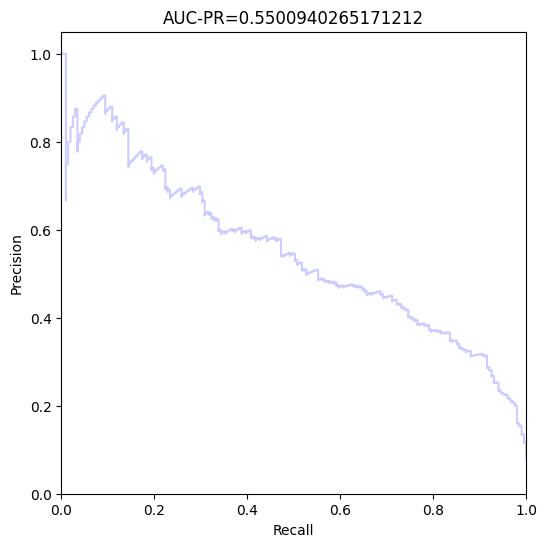

In [81]:
precision, recall, _ = metrics.precision_recall_curve(secondary_model_data[target_col], class_means)
average_precision = metrics.average_precision_score(secondary_model_data[target_col], class_means)

plt.figure(figsize=(6,6))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'AUC-PR={average_precision}')

In [82]:
for thr in thresholds[[x for x in range(len(thresholds)) if x%50==0]]:
    print('----')
    print(thr)
    print(f'TPR: {tpr[thresholds==thr][0]}')
    print(f'FPR: {fpr[thresholds==thr][0]}')

----
1.7956464612269345
TPR: 0.0
FPR: 0.0
----
0.318975053746993
TPR: 0.3383084577114428
FPR: 0.018061674008810574
----
0.19585834734500412
TPR: 0.572139303482587
FPR: 0.05418502202643172
----
0.13366957503745577
TPR: 0.746268656716418
FPR: 0.0920704845814978
----
0.07499066218957155
TPR: 0.9104477611940298
FPR: 0.1748898678414097


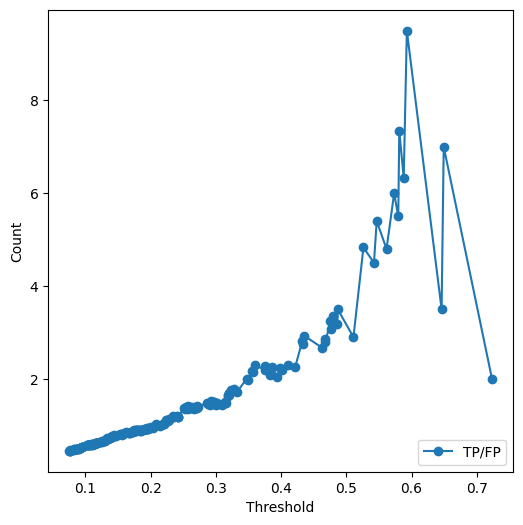

In [83]:
# Plot number of true positives and number of false positives as a function of the decision threshold for the first 50 thresholds, not fpr, but actual false positive count
tps = []
fps = []
max_ = 200

for thr in thresholds[3:max_]:
    _, fp, _, tp = metrics.confusion_matrix(secondary_model_data[target_col], class_means>=thr).ravel()
    tps.append(tp/fp)
    # fps.append(fp)

plt.figure(figsize=(6,6))
plt.plot(thresholds[3:max_], tps, label='TP/FP', marker='o')
# plt.plot(thresholds[3:max_], fps, label='FP')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.legend(loc="lower right")

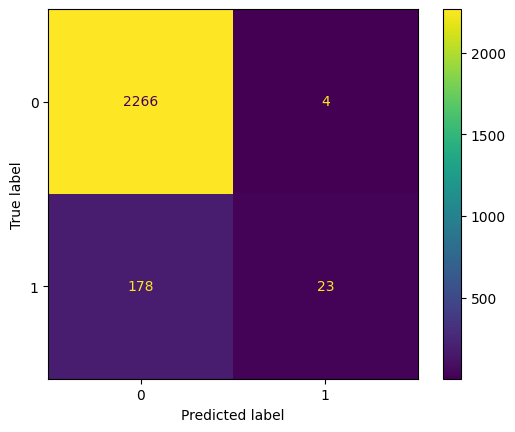

In [104]:
# opt_thresh = thresholds[np.argmax(np.sqrt(tpr*(1-fpr)))]
opt_thresh = thresholds[10]

y_true = secondary_model_data[target_col].values.ravel()
y_pred = class_means>opt_thresh
# y_pred = class_means>=opt_thresh

cm = metrics.confusion_matrix(y_true, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Regressor for low values

In [85]:
df_high = train_feats[train_feats['score']>score_thresh].copy()
df_low = train_feats[train_feats['score']<=score_thresh].copy()

In [86]:
OOF_ALL = np.zeros(len(df_high))
OOF_LOW_PREDS_HIGH = np.zeros(len(df_low))

models_dict = {}
preds_dict = {}
count = 0
for _ in df_low['id'].unique():
    preds_dict[count] = []
    count+=1

iterations = 5
n_splits = 10

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(df_low)):
        
        X_train, y_train = df_low.iloc[train_idx][train_cols], df_low.iloc[train_idx][target_col]
        X_valid, y_valid = df_low.iloc[valid_idx][train_cols], df_low.iloc[valid_idx][target_col]
        best_params = {
                "objective": "rmse",
                "metric": "rmse",
                'random_state': 41,
                "n_estimators" : 1000,
                "verbosity": -1,
                "n_jobs": -1,
            }
        
        model = lgb.LGBMRegressor(**best_params)
        early_stopping_callback = lgb.early_stopping(5, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)
        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        OOF_ALL += model.predict(df_high[train_cols]) / iterations / n_splits
        OOF_LOW_PREDS_HIGH += model.predict(df_low[train_cols]) / iterations / n_splits
        models_dict[f'{fold}_{i}'] = model

In [87]:
high_means = []
high_stds = []

for idx in preds_dict:
    high_means.append(np.mean(preds_dict[idx]))
    high_stds.append(np.std(preds_dict[idx]))

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(df_low[target_col], 
                                                                   np.array(high_means),
                                                                   squared=False)))

OOF metric LGBM = 0.40342


In [88]:
df_out = pd.DataFrame()
df_out['id'] = train_feats['id']
df_out['clf_pred'] = y_pred.astype(int)

In [89]:
df_low['reg pred'] = np.array(high_means)

df_high = train_feats[train_feats['score']>score_thresh].copy()
df_high['reg pred'] = OOF_ALL
df_low = df_low.merge(df_out, on='id', how='left')
df_high = df_high.merge(df_out, on='id', how='left')

df_all = pd.concat([df_high, df_low], axis=0)

In [90]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(df_all[df_all['clf_pred']==1][target_col], 
                                                                   df_all[df_all['clf_pred']==1]['reg pred'],
                                                                   squared=False)))

OOF metric LGBM = 0.58681


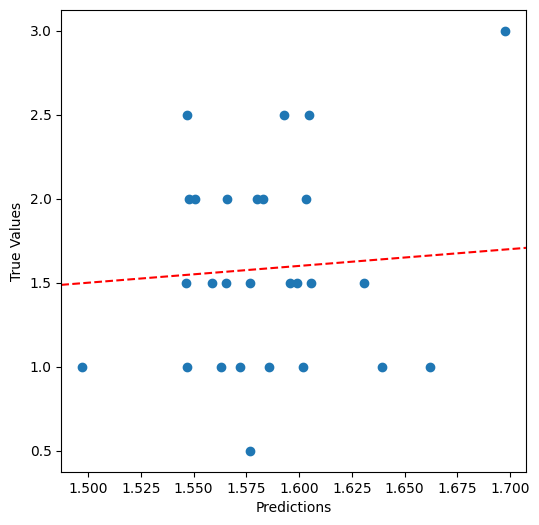

In [91]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_all[df_all['clf_pred']==1]['reg pred'], df_all[df_all['clf_pred']==1][target_col])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

In [96]:
out = pd.read_csv('../lgbm_v2_features0.csv')

In [98]:
out = out.merge(df_all, on='id', how='left')
out.loc[out['clf_pred']==1, 'pred'] = out.loc[out['clf_pred']==1, 'reg pred']

In [99]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(out[target_col], 
                                                                   out['pred'],
                                                                   squared=False)))

OOF metric LGBM = 0.62799
